This notebook has functions for loading and plotting a cumulative displacement time series at a single pixel, for both sequential igrams and for skip1 igrams, to compare them.
<br>
***
***
<br>
This notebook was written 9-27-23.

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import random
%matplotlib  widget

Load reference pixels and calculate ref vals for each igram using elevations/dem and slopes of topography-dependent slopes.

In [2]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# larger cropped area with western mountains 
dx = 4000
dy = 1100
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
seq_igram_dates = slc_dates[1::]
skip1_igram_dates = seq_igram_dates[1::]
# create conversion from radians to cm 
wavelength = 5.5465763                                      # C-band, in cm 
rad2cm = wavelength/(4*np.pi)  
# load reference pixels mask 
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')
# filter size for calculating average reference pixels phase value for each igram.
alooks=4*4
rlooks=20*4
# filter it to use for reference pixel phase calculation.
ref_mask_filt = gaussian_filter(ref_mask,sigma = [alooks/2,rlooks/2])
# initiate arrays for slopes and intercepts 
slopes_seq = np.ndarray((numIgrams,),dtype='float')
slopes_skip1 = np.ndarray((numIgrams,),dtype='float')
intercepts_seq = np.ndarray((numIgrams,),dtype='float')
intercepts_skip1 = np.ndarray((numIgrams,),dtype='float')
avg_ref_vals_seq = np.ndarray((numIgrams,),dtype='float')
avg_ref_vals_skip1 = np.ndarray((numIgrams,),dtype='float')
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
# define igrams directory 
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'
# load the DEM
driver=gdal.GetDriverByName('ISCE')
demDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/geom_reference'
x1 = 18000; x2 = 14000
y1 = 2100;  y2 = 1000
file = demDir+'/hgt.rdr.full'
ds = gdal.Open(file,gdal.GA_ReadOnly)
elev = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
elev_min = min(elev.flatten())
elev_cutoff = 150
els = elev.flatten()[(elev.flatten() > elev_cutoff)]
print('DEM loaded.')
# ignore the divide-by-zero error messages that pop up in each loop iteration.
np.seterr(divide='ignore', invalid='ignore')
# loop through igrams and calculate slope, intercept of topography-dependence 
for i in range(numIgrams):
    igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    # add condition that elevations over 125 m (relationship applies best for bedrock/high elevations)
    phs = temp_igram.flatten()[(elev.flatten() > elev_cutoff)]
    m, b = np.polyfit(els,phs,1)
    slopes_seq[i] = m
    intercepts_seq[i] = b
    # remove the topography effects
    temp_igram = temp_igram - (elev-elev_min)*slopes_seq[i] # + intercepts[i]
    # Now mask the igram based on ref pixels and filter it.
    igram_masked = np.zeros((dy,dx))
    igram_masked[mask_y,mask_x] = temp_igram[mask_y,mask_x]
    igram_filt = gaussian_filter(igram_masked,sigma = [alooks/2,rlooks/2])
    ab = igram_filt / ref_mask_filt
    avg_ref_vals_seq[i] = np.nanmean(ab) 
    print('i: '+str(i)+'\tavg_ref_val (seq): '+str('%.4f' % avg_ref_vals_seq[i]))
    # for skip1 igrams, don't need to do the loop for the index of the very last seq igram 
    if i<numIgrams-1:
        skip1igramFile = igramsDir+dates[i]+'_'+dates[i+2]+'_unfilt.unw'
        ds = gdal.Open(skip1igramFile,gdal.GA_ReadOnly)
        temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
        # add condition that elevations over 125 m (relationship applies best for bedrock/high elevations)
        phs = temp_igram.flatten()[(elev.flatten() > elev_cutoff)]
        m, b = np.polyfit(els,phs,1)
        slopes_skip1[i] = m
        intercepts_skip1[i] = b
        # remove the topography effects
        temp_igram = temp_igram - (elev-elev_min)*slopes_skip1[i] # + intercepts[i]
        # Now mask the igram based on ref pixels and filter it.
        igram_masked = np.zeros((dy,dx))
        igram_masked[mask_y,mask_x] = temp_igram[mask_y,mask_x]
        igram_filt = gaussian_filter(igram_masked,sigma = [alooks/2,rlooks/2])
        ab = igram_filt / ref_mask_filt
        avg_ref_vals_skip1[i] = np.nanmean(ab) 
        print('\tavg_ref_val (skip1): '+str('%.4f' % avg_ref_vals_skip1[i]))
print('Avg value of ref pixels calculated for all igrams.')
# save space/RAM and clean up these variables now. 
del igramFile, ds, temp_igram

Reference pixel mask loaded.


DEM loaded.
i: 0	avg_ref_val (seq): 0.8398
	avg_ref_val (skip1): 6.5541
i: 1	avg_ref_val (seq): 5.7130
	avg_ref_val (skip1): 3.2329
i: 2	avg_ref_val (seq): 3.7992
	avg_ref_val (skip1): 7.5559
i: 3	avg_ref_val (seq): 3.7529
	avg_ref_val (skip1): 3.9686
i: 4	avg_ref_val (seq): 6.4950
	avg_ref_val (skip1): 0.1941
i: 5	avg_ref_val (seq): -6.3085
	avg_ref_val (skip1): 3.6642
i: 6	avg_ref_val (seq): 9.9731
	avg_ref_val (skip1): 1.8927
i: 7	avg_ref_val (seq): -1.7975
	avg_ref_val (skip1): -2.7227
i: 8	avg_ref_val (seq): 5.3528
	avg_ref_val (skip1): 6.7063
i: 9	avg_ref_val (seq): 1.3449
	avg_ref_val (skip1): 3.0483
i: 10	avg_ref_val (seq): 1.7233
	avg_ref_val (skip1): 1.7482
i: 11	avg_ref_val (seq): 6.3033
	avg_ref_val (skip1): 5.9674
i: 12	avg_ref_val (seq): 5.9253
	avg_ref_val (skip1): 2.3140
i: 13	avg_ref_val (seq): 2.6652
	avg_ref_val (skip1): 2.1515
i: 14	avg_ref_val (seq): 5.7721
	avg_ref_val (skip1): 2.9740
i: 15	avg_ref_val (seq): 3.4966
	avg_ref_val (skip1): 3.3932
i: 16	avg_ref_val (

Define a function to extract a time series and pull out coherence over time at a specific point, after making corrections (subtract elev-depending ref value). Converts to cm also.

In [3]:
# j is interval, y is y-coord of pixel, x is x-coord of pixel
def time_series(j,y,x,avg_ref_vals,avg_ref_vals_skip1,elev,slopes,slopes_skip1):
    
    # choose one: 'filt' or 'unfilt'
    key1 = 'unfilt'
    # choose one: 'avg_val' or 'ref_box' or 'ref_pix'
    key2 = 'ref_pix'
    
    #igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
    igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'
    # cohDir =   '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
    cohDir =     '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
    #saveDir =   '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_for_intervals/'
    saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'
    
    # this one is to pick out the dates 
    datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
    # load in dates, make sure they are in order
    dates = [os.path.basename(d) for d in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
    nd = len(dates); numIgrams = nd-1
    
    start_indices = [0,47,108,147,0,0,107]
    end_indices = [46,107,146,numIgrams,88,numIgrams,153]

    # larger cropped area with western mountains 
    dx = 4000
    dy = 1100

    # pick out indices from the interval (interval j)
    interval_length = end_indices[j]-start_indices[j]
    print(str(interval_length)+' dates in interval '+str(j)+'.')
    
    # set up temp arrays for the row I'm extracting each time 
    temp_phs = np.ndarray((interval_length,),dtype='float')
    temp_phs_skip1 = np.ndarray((interval_length,),dtype='float')
    temp_coh = np.ndarray((interval_length,),dtype='float')
    temp_coh_skip1 = np.ndarray((interval_length,),dtype='float')

    elev_min = min(elev.flatten())

    # load in phase values for single pixel, correct them (subtract avg ref value), load coherences for that row of pix
    for i in range(interval_length):
        #print(start_indices[j]+i)
        date1 = dates[start_indices[j]+i]
        date2 = dates[start_indices[j]+i+1]
        igramFile = igramsDir+date1+'_'+date2+'_'+key1+'.unw'
        ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
        # only reading in one row at a time 
        temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)     # (startx,starty,dx,dy)  
        # correct for topography 
        temp_phs[i] = temp_phs[i] - (elev[y,x]-elev_min)*slopes[i] # + intercepts[i])
        # correct based on avg ref values and topography correction
        temp_phs[i] = temp_phs[i] - avg_ref_vals[start_indices[j]+i]
        # load one line of coherence files
        cohFile = 'coh_'+date1+'-'+date2+'.r4'
        ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
        # only reading in one row at a time
        temp_coh[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)

        # for skip1 igrams 
        if i<interval_length-1:
            #print(start_indices[j]+i)
            date1 = dates[start_indices[j]+i]
            date2 = dates[start_indices[j]+i+2]
            igramFile = igramsDir+date1+'_'+date2+'_'+key1+'.unw'
            ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
            # only reading in one row at a time 
            temp_phs_skip1[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)     # (startx,starty,dx,dy)  
            # correct for topography 
            temp_phs_skip1[i] = temp_phs_skip1[i] - (elev[y,x]-elev_min)*slopes_skip1[i] # + intercepts[i])
            # correct based on avg ref values and topography correction
            temp_phs_skip1[i] = temp_phs_skip1[i] - avg_ref_vals_skip1[start_indices[j]+i]
            # load one line of coherence files
            cohFile = 'coh_'+date1+'-'+date2+'.r4'
            ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
            # only reading in one row at a time
            temp_coh_skip1[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)

    # times of SLCs in interval j
    # dates is a list of strings, convert strings to datetime objects 
    slc_dates=[]
    for i in range(0,len(dates)):
        slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
    t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]   # so igram dates are t[1::], this line is for better plotting

    # coherence at that pixel over the interval, use this to calc variance.
    coh_at_pixel = temp_coh                                     # all dates, just the one pixel 
    coh_skip1 = temp_coh_skip1
    disps = np.copy(temp_phs)                                            # this is disp over igrams in interval, for the single pixel  
    disps_skip1 = np.copy(temp_phs_skip1)
    # Calculate cumulative displacement to do simple polyfit for comparison with weighted fit.
    cum_disps_seq = np.hstack((0,np.cumsum(disps)))
    cum_disps_skip1 = np.hstack((0,np.cumsum(disps_skip1)))
    # make a conversion factor from radians to cm. 
    wavelength = 5.5465763                                      # C-band, in cm 
    rad2cm = wavelength/(4*np.pi)                               # this is conversion factor that I multiply by the data (which is in rads)
    cum_disps_seq = cum_disps_seq*rad2cm
    cum_disps_skip1 = cum_disps_skip1*rad2cm

    # also produce cum_disps_skip1

    return t_datetime, cum_disps_seq, cum_disps_skip1, coh_at_pixel, coh_skip1

Load mask of the 2 populations so I know if the pixel I'm plotting is in pop1, pop2, or neither.

In [4]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/'
file1 = 'pop1_mask.r4'
#file1 = 'pop1_mask_version2.r4'
f1 = gdal.Open(loadDir+file1, gdal.GA_ReadOnly)
pop1_mask = f1.ReadAsArray()
f1 = None
file2 = 'pop2_mask.r4'
#file2 = 'pop2_mask_version2.r4'
f1 = gdal.Open(loadDir+file2, gdal.GA_ReadOnly)
pop2_mask = f1.ReadAsArray()
f1 = None
print('pop1 and pop2 masks loaded.')
pops = np.zeros((dy,dx))
pops[pop1_mask==1.0]=1.0
pops[pop2_mask==1.0]=2.0

pop1 and pop2 masks loaded.


Print out a list of y,x coordinates in each population. This takes a while and there are a lot of outputs.

In [5]:
# OPTIONAL
# print('pop1\t\tpop2')
# for y in range(dy):
#     for x in range(dx):
#         if pops[y,x]==1:
#             print(str(y)+','+str(x))
#         elif pops[y,x]==2:
#             print('\t\t'+str(y)+','+str(x))

Or instead of above: choose a random pixel until it gets one that is pop1 or pop2.

In [6]:
y_temp = random.randint(0,dy)
x_temp = random.randint(0,dx)

while pops[y_temp,x_temp] != 2.0:
    y_temp = random.randint(0,dy)
    x_temp = random.randint(0,dx)
print(str(y_temp)+','+str(x_temp)+'  pop '+str(pops[y_temp,x_temp]))

681,898  pop 2e+00


In [7]:
# define which interval and which pixel we want the time series for 
j = 5
# x = 500
# y = 500

y = 462
x = 3836

y=y_temp
x=x_temp

print('pixel in population: '+str(str(pops[y,x])))

t_datetime, cum_disps_seq, cum_disps_skip1, coh_seq, coh_skip1 = time_series(j,y,x,avg_ref_vals_seq,avg_ref_vals_skip1,elev,slopes_seq,slopes_skip1)

pixel in population: 2.0
210 dates in interval 5.


In [8]:
# print(np.shape(slc_dates))
# print(np.shape(skip1_igram_dates))
# print(np.shape(cum_disps_skip1))

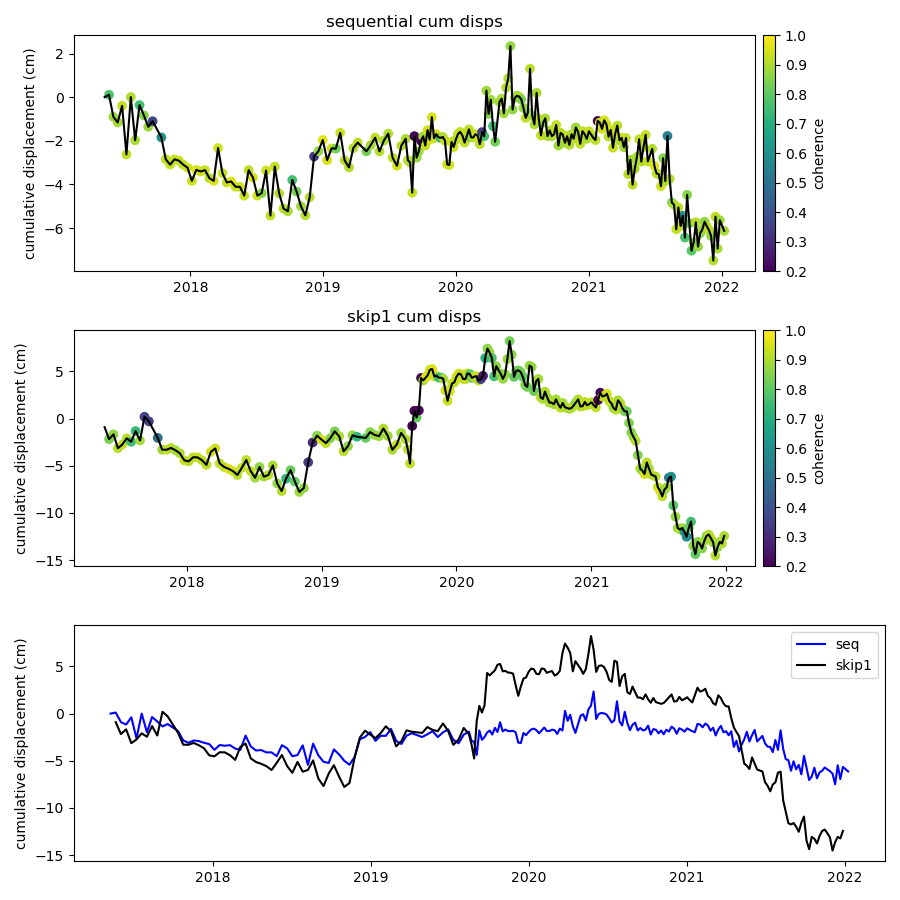

In [9]:
plt.figure(figsize=(9,9),tight_layout=True)
plt.subplot(3,1,1)
plt.plot(slc_dates,cum_disps_seq,'k-')
plt.scatter(seq_igram_dates,cum_disps_seq[1::],c=coh_seq,cmap='viridis',vmin=0.2,vmax=1)
plt.title('sequential cum disps')
plt.ylabel('cumulative displacement (cm)')
#plt.legend(loc='lower left')
plt.colorbar(label='coherence',pad=0.01)
plt.subplot(3,1,2)
plt.plot(slc_dates[1:-1],cum_disps_skip1[1:-1],'k-')
plt.scatter(skip1_igram_dates[0:-1],cum_disps_skip1[2:-1],c=coh_skip1[1:-1],cmap='viridis',vmin=0.2,vmax=1)
plt.title('skip1 cum disps')
plt.ylabel('cumulative displacement (cm)')
#plt.legend(loc='lower left')
plt.colorbar(label='coherence',pad=0.01)
plt.subplot(3,1,3)
plt.plot(slc_dates,cum_disps_seq,'b-',label='seq')
plt.plot(slc_dates[1:-1],cum_disps_skip1[1:-1],'k-',label='skip1')
plt.ylabel('cumulative displacement (cm)')
plt.legend()
plt.show()
